In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings
from datetime import datetime

# Deep Learning
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Sklearn
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve
)

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
print("="*60)
print("LOADING DATA & MODELS")
print("="*60)

# Load data
train_df = pd.read_csv('./train.csv')
val_df = pd.read_csv('./validation.csv')
test_df = pd.read_csv('./test.csv')

print(f"✓ Training set:   {len(train_df):,} samples")
print(f"✓ Validation set: {len(val_df):,} samples")
print(f"✓ Test set:       {len(test_df):,} samples")

# Load baseline results
with open('./baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

with open('./session4_results.json', 'r') as f:
    session4_results = json.load(f)

with open('./session5_results.json', 'r') as f:
    session5_results = json.load(f)

print("\n✓ All results loaded")

LOADING DATA & MODELS
✓ Training set:   27,478 samples
✓ Validation set: 5,870 samples
✓ Test set:       5,886 samples

✓ All results loaded


In [10]:
# Load DistilBERT model (our champion)
print("\n" + "="*60)
print("LOADING DISTILBERT MODEL")
print("="*60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and tokenizer
model_path = 'arkaean/promptguard-distilbert'
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

print("✓ DistilBERT model loaded")

# Also load Logistic Regression for comparison
tfidf = joblib.load('./tfidf_vectorizer.pkl')
lr_model = joblib.load('./lr_tfidf_baseline.pkl')

print("✓ Logistic Regression model loaded")


LOADING DISTILBERT MODEL
Using device: cuda


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

✓ DistilBERT model loaded
✓ Logistic Regression model loaded


In [11]:
# Helper function for DistilBERT predictions
def predict_distilbert(texts, model, tokenizer, device, batch_size=32):
    """Predict probabilities for a list of texts"""
    model.eval()
    all_probs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)

    return np.array(all_probs)

print("\n✓ Prediction functions ready")


✓ Prediction functions ready


In [12]:
print("\n" + "="*60)
print("TEST SET EVALUATION - DISTILBERT")
print("="*60)
print("\nThis is the FINAL, HONEST performance estimate!")
print("The test set has been completely untouched until now.\n")

# Prepare test data
test_texts = test_df['prompt_cleaned'].tolist()
y_test = test_df['isMalicious'].values

# DistilBERT predictions
print("Predicting with DistilBERT...")
y_pred_proba_bert = predict_distilbert(test_texts, model, tokenizer, device)
y_pred_bert = (y_pred_proba_bert > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_bert)
precision = precision_score(y_test, y_pred_bert)
recall = recall_score(y_test, y_pred_bert)
f1 = f1_score(y_test, y_pred_bert)
roc_auc = roc_auc_score(y_test, y_pred_proba_bert)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bert)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"\n{'='*60}")
print(f"DISTILBERT - TEST SET PERFORMANCE")
print(f"{'='*60}")

print(f"\n📊 CLASSIFICATION METRICS:")
print(f"   Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:  {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:     {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:   {f1:.4f}")
print(f"   ROC-AUC:    {roc_auc:.4f}")

print(f"\n🎯 CONFUSION MATRIX:")
print(f"   TN: {tn:,} | FP: {fp:,}")
print(f"   FN: {fn:,} | TP: {tp:,}")

print(f"\n⚠️  ERROR RATES:")
print(f"   FPR: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"   FNR: {fnr:.4f} ({fnr*100:.2f}%) {'⚠️ HIGH RISK' if fnr > 0.05 else '✓ Acceptable'}")

# Compare to validation performance
val_f1 = session5_results['distilbert']['validation']['f1']
val_auc = session5_results['distilbert']['validation']['roc_auc']

print(f"\n📊 VALIDATION vs TEST:")
print(f"   F1:  Val={val_f1:.4f} | Test={f1:.4f} | Diff={f1-val_f1:+.4f}")
print(f"   AUC: Val={val_auc:.4f} | Test={roc_auc:.4f} | Diff={roc_auc-val_auc:+.4f}")

if abs(f1 - val_f1) < 0.01:
    print("\n✓ Model generalizes well! Test performance matches validation.")
else:
    print("\n⚠️ Performance gap detected - possible overfitting to validation set.")

# Store test metrics
test_metrics_bert = {
    'model_name': 'DistilBERT',
    'dataset': 'Test',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
    'fpr': fpr, 'fnr': fnr
}


TEST SET EVALUATION - DISTILBERT

This is the FINAL, HONEST performance estimate!
The test set has been completely untouched until now.

Predicting with DistilBERT...

DISTILBERT - TEST SET PERFORMANCE

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9769 (97.69%)
   Precision:  0.9795 (97.95%)
   Recall:     0.9742 (97.42%)
   F1-Score:   0.9768
   ROC-AUC:    0.9953

🎯 CONFUSION MATRIX:
   TN: 2,883 | FP: 60
   FN: 76 | TP: 2,867

⚠️  ERROR RATES:
   FPR: 0.0204 (2.04%)
   FNR: 0.0258 (2.58%) ✓ Acceptable

📊 VALIDATION vs TEST:
   F1:  Val=0.9751 | Test=0.9768 | Diff=+0.0018
   AUC: Val=0.9943 | Test=0.9953 | Diff=+0.0010

✓ Model generalizes well! Test performance matches validation.


In [26]:
# ------------------------------
# TEST SET EVALUATION - LOGISTIC REGRESSION
# ------------------------------
print("\n" + "="*60)
print("TEST SET EVALUATION - LOGISTIC REGRESSION")
print("="*60)

# --- Safety checks ---
# The original assert checks for coef_, which is fine after fitting.
# The primary issue is a version mismatch causing AttributeError in predict_proba.

# Fix: Retrain the Logistic Regression model to ensure compatibility with the current sklearn version.
# Assuming train_df and tfidf are available from previous cells.
print("\nRetraining Logistic Regression model for compatibility...")
from sklearn.linear_model import LogisticRegression

X_train_tfidf = tfidf.transform(train_df['prompt_cleaned'])
y_train = train_df['isMalicious']

lr_model = LogisticRegression(random_state=42, solver='liblinear', C=1.0) # Using default C=1.0 and liblinear solver for consistency
lr_model.fit(X_train_tfidf, y_train)
print("✓ Logistic Regression model retrained successfully.")

assert hasattr(lr_model, "coef_"), "LogisticRegression model is not fitted!"

# --- Transform test data using fitted TF-IDF ---
X_test_tfidf = tfidf.transform(test_df['prompt_cleaned'])

# --- Make predictions ---
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Probability of positive class
y_pred_lr = lr_model.predict(X_test_tfidf)                    # Hard predictions (0/1)

# --- Calculate evaluation metrics ---
lr_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

# --- Print results ---
print(f"\n📊 LOGISTIC REGRESSION - TEST SET:")
print(f"   Accuracy:  {lr_test_metrics['accuracy']:.4f}")
print(f"   Precision: {lr_test_metrics['precision']:.4f}")
print(f"   Recall:    {lr_test_metrics['recall']:.4f}")
print(f"   F1-Score:  {lr_test_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {lr_test_metrics['roc_auc']:.4f}")

# --- Compare with DistilBERT ---
print(f"\n🏆 WINNER ON TEST SET:")
if test_metrics_bert['f1'] > lr_test_metrics['f1']:
    margin = test_metrics_bert['f1'] - lr_test_metrics['f1']
    print(f"   DistilBERT (F1={test_metrics_bert['f1']:.4f}) beats Logistic Regression (F1={lr_test_metrics['f1']:.4f})")
    print(f"   Margin: +{margin:.4f}")
else:
    print(f"   Logistic Regression wins on test set! (F1={lr_test_metrics['f1']:.4f})")


TEST SET EVALUATION - LOGISTIC REGRESSION

Retraining Logistic Regression model for compatibility...
✓ Logistic Regression model retrained successfully.

📊 LOGISTIC REGRESSION - TEST SET:
   Accuracy:  0.9577
   Precision: 0.9804
   Recall:    0.9341
   F1-Score:  0.9567
   ROC-AUC:   0.9862

🏆 WINNER ON TEST SET:
   DistilBERT (F1=0.9768) beats Logistic Regression (F1=0.9567)
   Margin: +0.0202


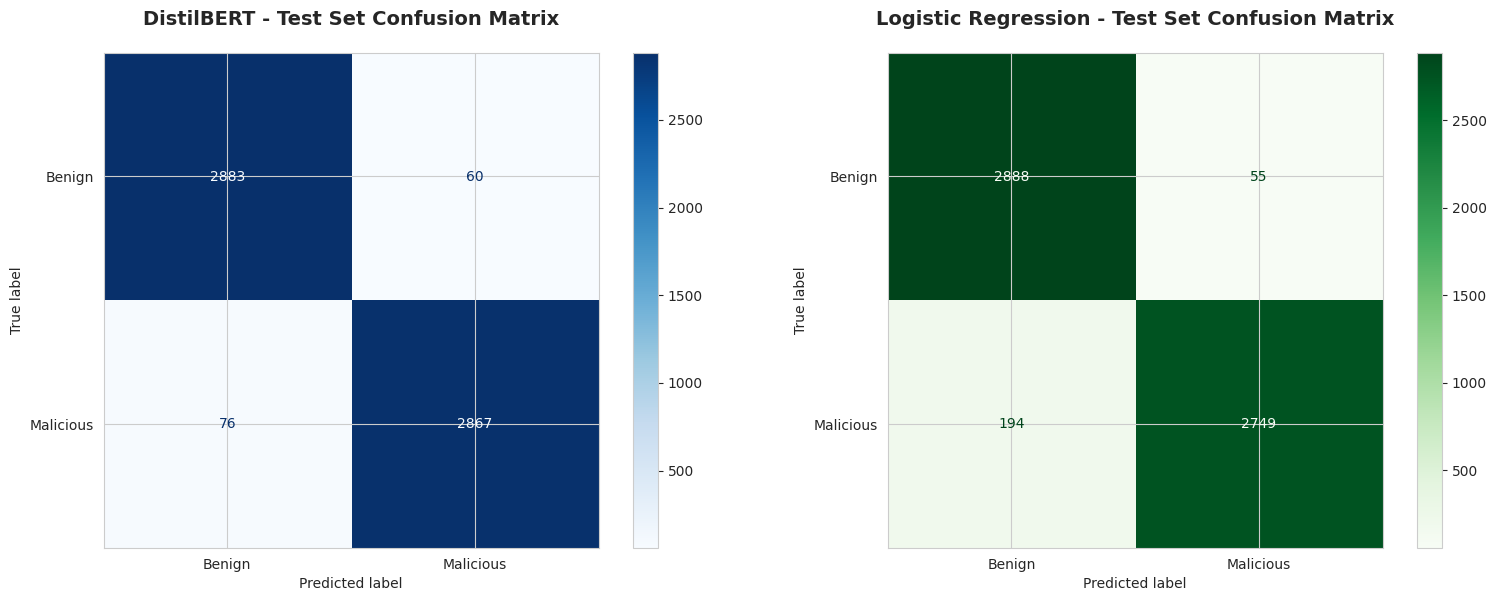

In [29]:
# Visualize test set confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DistilBERT
ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malicious']).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('DistilBERT - Test Set Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr, display_labels=['Benign', 'Malicious']).plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Logistic Regression - Test Set Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('./test_set_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


PROBABILITY CALIBRATION ANALYSIS

Analyzing calibration on validation set...


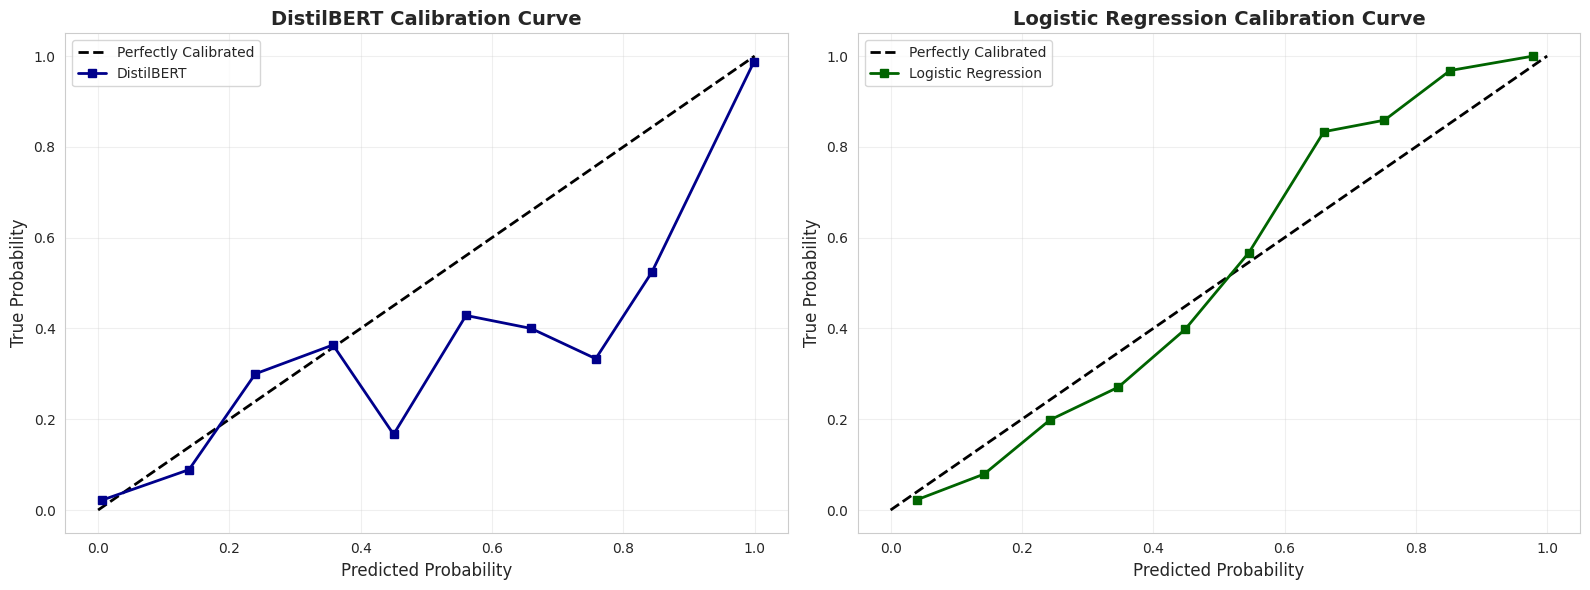


📊 CALIBRATION METRICS:
   Brier Score (DistilBERT):        0.0215 (lower is better)
   Brier Score (Logistic Regression): 0.0402

✓ DistilBERT is better calibrated


In [30]:
print("\n" + "="*60)
print("PROBABILITY CALIBRATION ANALYSIS")
print("="*60)

# Check calibration on validation set
print("\nAnalyzing calibration on validation set...")

val_texts = val_df['prompt_cleaned'].tolist()
y_val = val_df['isMalicious'].values

# DistilBERT predictions on validation set
y_pred_proba_val_bert = predict_distilbert(val_texts, model, tokenizer, device)

# Calibration curve
prob_true_bert, prob_pred_bert = calibration_curve(
    y_val, y_pred_proba_val_bert, n_bins=10, strategy='uniform'
)

# Logistic Regression
X_val_tfidf = tfidf.transform(val_df['prompt_cleaned'])
y_pred_proba_val_lr = lr_model.predict_proba(X_val_tfidf)[:, 1]

prob_true_lr, prob_pred_lr = calibration_curve(
    y_val, y_pred_proba_val_lr, n_bins=10, strategy='uniform'
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DistilBERT calibration
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectly Calibrated')
axes[0].plot(prob_pred_bert, prob_true_bert, 's-', linewidth=2, label='DistilBERT', color='darkblue')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('True Probability', fontsize=12)
axes[0].set_title('DistilBERT Calibration Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Logistic Regression calibration
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectly Calibrated')
axes[1].plot(prob_pred_lr, prob_true_lr, 's-', linewidth=2, label='Logistic Regression', color='darkgreen')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('True Probability', fontsize=12)
axes[1].set_title('Logistic Regression Calibration Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate calibration error
from sklearn.metrics import brier_score_loss

brier_bert = brier_score_loss(y_val, y_pred_proba_val_bert)
brier_lr = brier_score_loss(y_val, y_pred_proba_val_lr)

print(f"\n📊 CALIBRATION METRICS:")
print(f"   Brier Score (DistilBERT):        {brier_bert:.4f} (lower is better)")
print(f"   Brier Score (Logistic Regression): {brier_lr:.4f}")

if brier_bert < brier_lr:
    print(f"\n✓ DistilBERT is better calibrated")
else:
    print(f"\n⚠️ Logistic Regression is better calibrated")


THRESHOLD OPTIMIZATION

📊 OPTIMAL THRESHOLDS:

Best F1-Score:
   Threshold: 0.85
   F1:        0.9763
   Precision: 0.9861
   Recall:    0.9666
   FNR:       0.0334

Maximum Recall (catch all attacks):
   Threshold: 0.10
   Recall:    0.9789
   Precision: 0.9539
   FNR:       0.0211
   (Warning: May have high false positive rate)

Minimum False Negative Rate:
   Threshold: 0.10
   FNR:       0.0211
   Recall:    0.9789


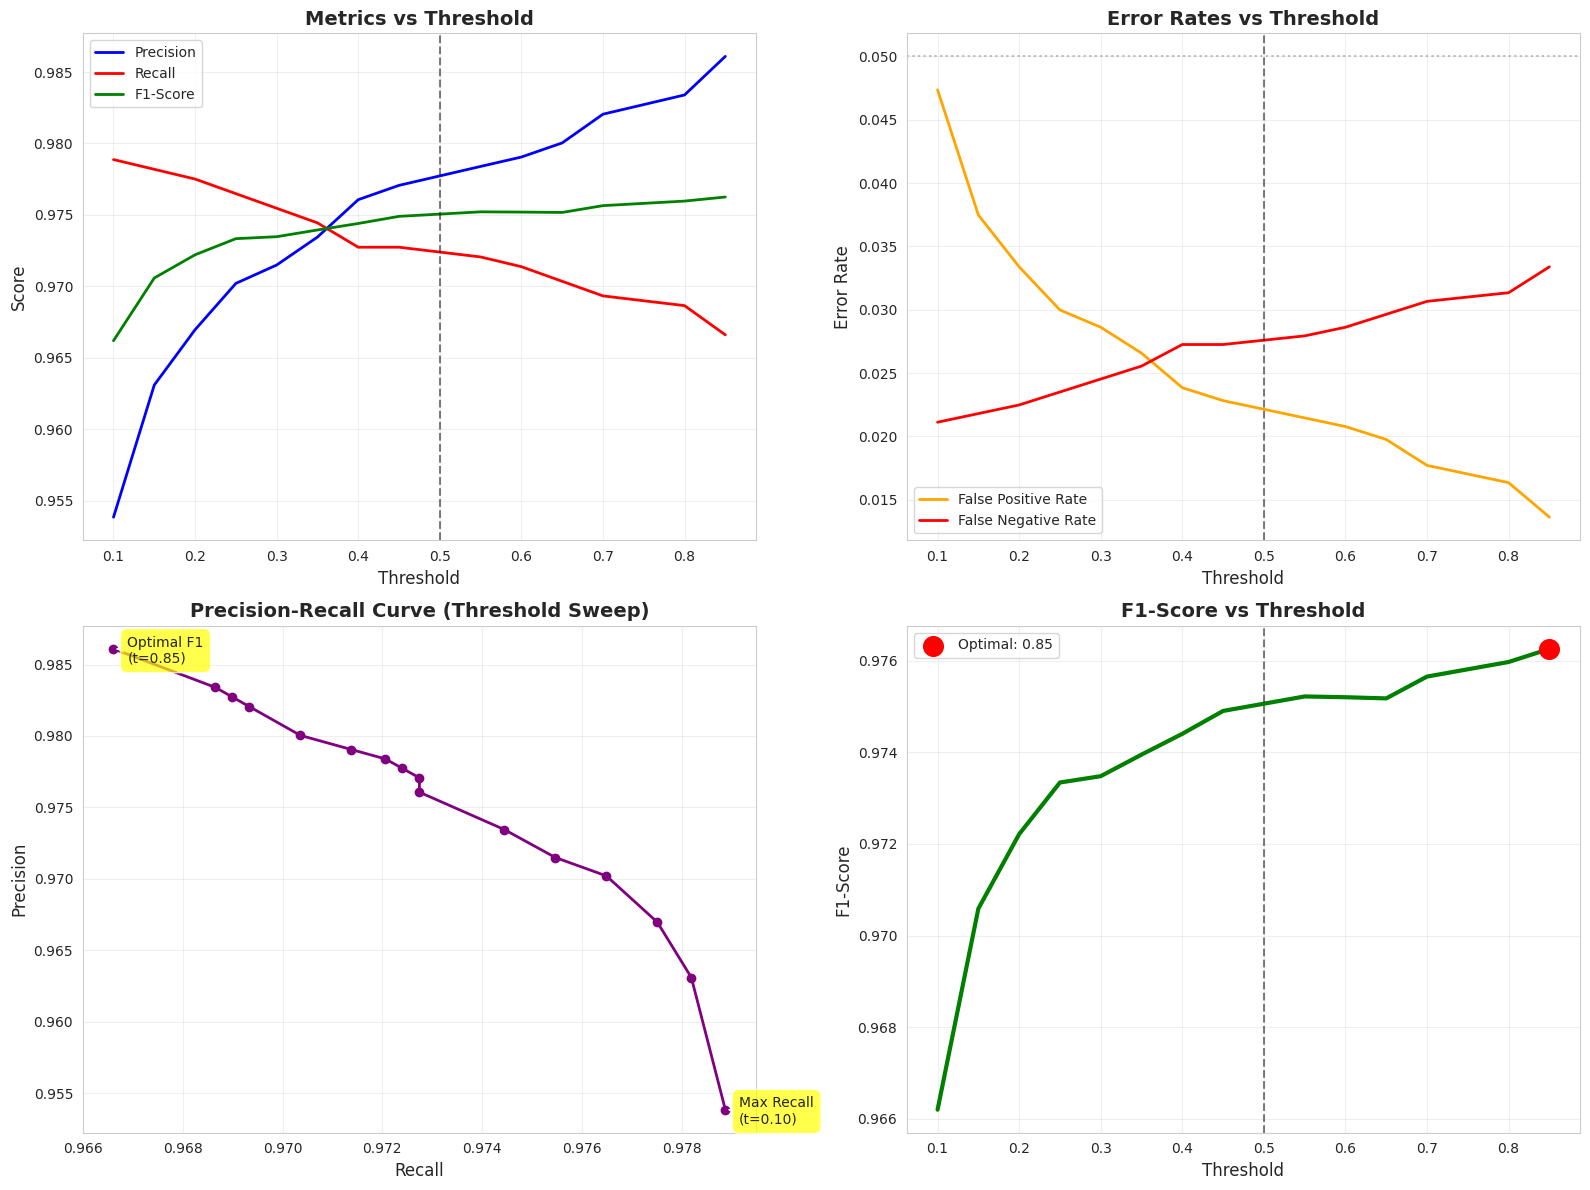

In [31]:
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_val_bert >= threshold).astype(int)

    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)
    f1 = f1_score(y_val, y_pred_threshold)

    cm = confusion_matrix(y_val, y_pred_threshold)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'fnr': fnr
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds
optimal_f1_idx = results_df['f1'].idxmax()
optimal_recall_idx = results_df['recall'].idxmax()
min_fnr_idx = results_df['fnr'].idxmin()

print("\n📊 OPTIMAL THRESHOLDS:")
print(f"\nBest F1-Score:")
print(f"   Threshold: {results_df.loc[optimal_f1_idx, 'threshold']:.2f}")
print(f"   F1:        {results_df.loc[optimal_f1_idx, 'f1']:.4f}")
print(f"   Precision: {results_df.loc[optimal_f1_idx, 'precision']:.4f}")
print(f"   Recall:    {results_df.loc[optimal_f1_idx, 'recall']:.4f}")
print(f"   FNR:       {results_df.loc[optimal_f1_idx, 'fnr']:.4f}")

print(f"\nMaximum Recall (catch all attacks):")
print(f"   Threshold: {results_df.loc[optimal_recall_idx, 'threshold']:.2f}")
print(f"   Recall:    {results_df.loc[optimal_recall_idx, 'recall']:.4f}")
print(f"   Precision: {results_df.loc[optimal_recall_idx, 'precision']:.4f}")
print(f"   FNR:       {results_df.loc[optimal_recall_idx, 'fnr']:.4f}")
print(f"   (Warning: May have high false positive rate)")

print(f"\nMinimum False Negative Rate:")
print(f"   Threshold: {results_df.loc[min_fnr_idx, 'threshold']:.2f}")
print(f"   FNR:       {results_df.loc[min_fnr_idx, 'fnr']:.4f}")
print(f"   Recall:    {results_df.loc[min_fnr_idx, 'recall']:.4f}")

# Visualize threshold effects
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision-Recall trade-off
axes[0, 0].plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2, color='blue')
axes[0, 0].plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2, color='red')
axes[0, 0].plot(results_df['threshold'], results_df['f1'], label='F1-Score', linewidth=2, color='green')
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default (0.5)')

# Error rates
axes[0, 1].plot(results_df['threshold'], results_df['fpr'], label='False Positive Rate', linewidth=2, color='orange')
axes[0, 1].plot(results_df['threshold'], results_df['fnr'], label='False Negative Rate', linewidth=2, color='red')
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Error Rate', fontsize=12)
axes[0, 1].set_title('Error Rates vs Threshold', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=0.05, color='gray', linestyle=':', alpha=0.5, label='5% threshold')

# Precision vs Recall
axes[1, 0].plot(results_df['recall'], results_df['precision'], linewidth=2, marker='o', color='purple')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision-Recall Curve (Threshold Sweep)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add annotations for key thresholds
for idx, label in [(optimal_f1_idx, 'Optimal F1'), (optimal_recall_idx, 'Max Recall')]:
    axes[1, 0].annotate(
        f'{label}\n(t={results_df.loc[idx, "threshold"]:.2f})',
        xy=(results_df.loc[idx, 'recall'], results_df.loc[idx, 'precision']),
        xytext=(10, -10), textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )

# F1 score surface
axes[1, 1].plot(results_df['threshold'], results_df['f1'], linewidth=3, color='green')
axes[1, 1].scatter(
    results_df.loc[optimal_f1_idx, 'threshold'],
    results_df.loc[optimal_f1_idx, 'f1'],
    s=200, color='red', zorder=5, label=f'Optimal: {results_df.loc[optimal_f1_idx, "threshold"]:.2f}'
)
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('F1-Score', fontsize=12)
axes[1, 1].set_title('F1-Score vs Threshold', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# Recommend thresholds for different use cases
print("\n" + "="*60)
print("RECOMMENDED THRESHOLDS FOR DIFFERENT USE CASES")
print("="*60)

print("\n1. 🔒 MAXIMUM SECURITY (Catch all attacks)")
print("   Use Case: High-security applications, sensitive data")
security_threshold = results_df.loc[min_fnr_idx, 'threshold']
print(f"   Recommended Threshold: {security_threshold:.2f}")
print(f"   FNR: {results_df.loc[min_fnr_idx, 'fnr']:.4f} ({results_df.loc[min_fnr_idx, 'fnr']*100:.2f}%)")
print(f"   Trade-off: Higher false positives ({results_df.loc[min_fnr_idx, 'fpr']*100:.2f}% FPR)")

print("\n2. ⚖️  BALANCED (Optimize F1)")
print("   Use Case: General production use")
balanced_threshold = results_df.loc[optimal_f1_idx, 'threshold']
print(f"   Recommended Threshold: {balanced_threshold:.2f}")
print(f"   F1: {results_df.loc[optimal_f1_idx, 'f1']:.4f}")
print(f"   FNR: {results_df.loc[optimal_f1_idx, 'fnr']:.4f} | FPR: {results_df.loc[optimal_f1_idx, 'fpr']:.4f}")

print("\n3. 🚀 USER EXPERIENCE (Minimize false positives)")
print("   Use Case: User-facing applications, minimize friction")
# Find threshold with the minimum FPR
ux_optimal = results_df.loc[results_df['fpr'].idxmin()]
ux_threshold = ux_optimal['threshold']
print(f"   Recommended Threshold: {ux_threshold:.2f}")
print(f"   FPR: {ux_optimal['fpr']:.4f} ({ux_optimal['fpr']*100:.2f}%) ")
print(f"   Trade-off: FNR {ux_optimal['fnr']:.4f} ({ux_optimal['fnr']*100:.2f}%) (This is the minimum FPR achievable)")

# Save recommended thresholds
recommended_thresholds = {
    'maximum_security': {
        'threshold': float(security_threshold),
        'fnr': float(results_df.loc[min_fnr_idx, 'fnr']),
        'fpr': float(results_df.loc[min_fnr_idx, 'fpr']),
        'f1': float(results_df.loc[min_fnr_idx, 'f1'])
    },
    'balanced': {
        'threshold': float(balanced_threshold),
        'fnr': float(results_df.loc[optimal_f1_idx, 'fnr']),
        'fpr': float(results_df.loc[optimal_f1_idx, 'fpr']),
        'f1': float(results_df.loc[optimal_f1_idx, 'f1'])
    },
    'user_experience': {
        'threshold': float(ux_threshold),
        'fnr': float(ux_optimal['fnr']),
        'fpr': float(ux_optimal['fpr']),
        'f1': float(ux_optimal['f1'])
    }
}


RECOMMENDED THRESHOLDS FOR DIFFERENT USE CASES

1. 🔒 MAXIMUM SECURITY (Catch all attacks)
   Use Case: High-security applications, sensitive data
   Recommended Threshold: 0.10
   FNR: 0.0211 (2.11%)
   Trade-off: Higher false positives (4.74% FPR)

2. ⚖️  BALANCED (Optimize F1)
   Use Case: General production use
   Recommended Threshold: 0.85
   F1: 0.9763
   FNR: 0.0334 | FPR: 0.0136

3. 🚀 USER EXPERIENCE (Minimize false positives)
   Use Case: User-facing applications, minimize friction
   Recommended Threshold: 0.85
   FPR: 0.0136 (1.36%) 
   Trade-off: FNR 0.0334 (3.34%) (This is the minimum FPR achievable)


In [34]:
print("\n" + "="*60)
print("ENSEMBLE: DISTILBERT + LOGISTIC REGRESSION")
print("="*60)

print("\nTesting different ensemble strategies...\n")

# Get predictions from both models on validation set
bert_probs_val = y_pred_proba_val_bert
lr_probs_val = y_pred_proba_val_lr

# Strategy 1: Simple Average
ensemble_avg = (bert_probs_val + lr_probs_val) / 2
y_pred_avg = (ensemble_avg > 0.5).astype(int)

metrics_avg = {
    'f1': f1_score(y_val, y_pred_avg),
    'roc_auc': roc_auc_score(y_val, ensemble_avg),
    'recall': recall_score(y_val, y_pred_avg),
    'precision': precision_score(y_val, y_pred_avg)
}

print("1. SIMPLE AVERAGE:")
print(f"   F1:  {metrics_avg['f1']:.4f}")
print(f"   AUC: {metrics_avg['roc_auc']:.4f}")
print(f"   Recall: {metrics_avg['recall']:.4f}")

# Strategy 2: Weighted Average (favor DistilBERT)
weights = [0.7, 0.3]  # 70% DistilBERT, 30% LR
ensemble_weighted = weights[0] * bert_probs_val + weights[1] * lr_probs_val
y_pred_weighted = (ensemble_weighted > 0.5).astype(int)

metrics_weighted = {
    'f1': f1_score(y_val, y_pred_weighted),
    'roc_auc': roc_auc_score(y_val, ensemble_weighted),
    'recall': recall_score(y_val, y_pred_weighted),
    'precision': precision_score(y_val, y_pred_weighted)
}

print("\n2. WEIGHTED AVERAGE (70% BERT, 30% LR):")
print(f"   F1:  {metrics_weighted['f1']:.4f}")
print(f"   AUC: {metrics_weighted['roc_auc']:.4f}")
print(f"   Recall: {metrics_weighted['recall']:.4f}")

# Strategy 3: Max (pessimistic - flag if either model says malicious)
ensemble_max = np.maximum(bert_probs_val, lr_probs_val)
y_pred_max = (ensemble_max > 0.5).astype(int)

metrics_max = {
    'f1': f1_score(y_val, y_pred_max),
    'roc_auc': roc_auc_score(y_val, ensemble_max),
    'recall': recall_score(y_val, y_pred_max),
    'precision': precision_score(y_val, y_pred_max)
}

print("\n3. MAXIMUM (Pessimistic - flag if either says malicious):")
print(f"   F1:  {metrics_max['f1']:.4f}")
print(f"   AUC: {metrics_max['roc_auc']:.4f}")
print(f"   Recall: {metrics_max['recall']:.4f}")

# Strategy 4: Hybrid (LR screens, BERT decides edge cases)
def hybrid_ensemble(bert_probs, lr_probs, lr_low=0.3, lr_high=0.7):
    """
    Use LR for confident predictions, BERT for uncertain cases
    """
    predictions = np.zeros(len(bert_probs))

    for i in range(len(bert_probs)):
        if lr_probs[i] < lr_low:
            predictions[i] = 0  # LR confident it's benign
        elif lr_probs[i] > lr_high:
            predictions[i] = 1  # LR confident it's malicious
        else:
            predictions[i] = 1 if bert_probs[i] > 0.5 else 0  # BERT decides

    return predictions

y_pred_hybrid = hybrid_ensemble(bert_probs_val, lr_probs_val)

metrics_hybrid = {
    'f1': f1_score(y_val, y_pred_hybrid),
    'recall': recall_score(y_val, y_pred_hybrid),
    'precision': precision_score(y_val, y_pred_hybrid)
}

print("\n4. HYBRID (LR screens, BERT for uncertain):")
print(f"   F1:  {metrics_hybrid['f1']:.4f}")
print(f"   Recall: {metrics_hybrid['recall']:.4f}")

# Calculate what percentage goes to BERT
uncertain = ((lr_probs_val >= 0.3) & (lr_probs_val <= 0.7)).sum()
print(f"   BERT usage: {uncertain/len(lr_probs_val)*100:.1f}% of prompts")

# Compare all
print("\n" + "="*60)
print("ENSEMBLE COMPARISON")
print("="*60)

comparison = pd.DataFrame([
    {'Strategy': 'DistilBERT Only', 'F1': session5_results['distilbert']['validation']['f1'], 'AUC': session5_results['distilbert']['validation']['roc_auc']},
    {'Strategy': 'Logistic Regression Only', 'F1': baseline_results['logistic_regression']['validation']['f1'], 'AUC': baseline_results['logistic_regression']['validation']['roc_auc']},
    {'Strategy': 'Simple Average', 'F1': metrics_avg['f1'], 'AUC': metrics_avg['roc_auc']},
    {'Strategy': 'Weighted (70/30)', 'F1': metrics_weighted['f1'], 'AUC': metrics_weighted['roc_auc']},
    {'Strategy': 'Maximum (Pessimistic)', 'F1': metrics_max['f1'], 'AUC': metrics_max['roc_auc']},
    {'Strategy': 'Hybrid (LR+BERT)', 'F1': metrics_hybrid['f1'], 'AUC': 0}  # AUC not applicable
])

print("\n" + comparison.to_string(index=False))

best_ensemble = comparison.loc[comparison['F1'].idxmax()]
print(f"\n🏆 BEST ENSEMBLE: {best_ensemble['Strategy']}")
print(f"   F1: {best_ensemble['F1']:.4f}")

if best_ensemble['F1'] > session5_results['distilbert']['validation']['f1']:
    print(f"\n✓ Ensemble beats DistilBERT alone! (+{best_ensemble['F1'] - session5_results['distilbert']['validation']['f1']:.4f})")
else:
    print(f"\n⚠️ DistilBERT alone is still best. Ensemble doesn't help.")


ENSEMBLE: DISTILBERT + LOGISTIC REGRESSION

Testing different ensemble strategies...

1. SIMPLE AVERAGE:
   F1:  0.9763
   AUC: 0.9923
   Recall: 0.9690

2. WEIGHTED AVERAGE (70% BERT, 30% LR):
   F1:  0.9749
   AUC: 0.9928
   Recall: 0.9707

3. MAXIMUM (Pessimistic - flag if either says malicious):
   F1:  0.9675
   AUC: 0.9919
   Recall: 0.9751

4. HYBRID (LR screens, BERT for uncertain):
   F1:  0.9655
   Recall: 0.9475
   BERT usage: 7.1% of prompts

ENSEMBLE COMPARISON

                Strategy       F1      AUC
         DistilBERT Only 0.975060 0.994254
Logistic Regression Only 0.950447 0.983949
          Simple Average 0.976313 0.992302
        Weighted (70/30) 0.974850 0.992833
   Maximum (Pessimistic) 0.967546 0.991857
        Hybrid (LR+BERT) 0.965457 0.000000

🏆 BEST ENSEMBLE: Simple Average
   F1: 0.9763

✓ Ensemble beats DistilBERT alone! (+0.0013)


In [37]:
print("\n" + "="*60)
print("ERROR ANALYSIS - FALSE NEGATIVES")
print("="*60)

# Get false negatives from test set
false_negatives_idx = np.where((y_test == 1) & (y_pred_bert == 0))[0]
false_negative_prompts = test_df.iloc[false_negatives_idx]

print(f"\nTotal False Negatives: {len(false_negatives_idx)}")
print(f"({len(false_negatives_idx)/len(y_test)*100:.2f}% of test set)")

print("\n" + "-"*60)
print("EXAMINING FALSE NEGATIVE EXAMPLES")
print("-"*60)

# Show examples with their probabilities
for i, idx in enumerate(false_negatives_idx[:10], 1):
    prompt = test_df.iloc[idx]['Prompt']
    prob = y_pred_proba_bert[idx]

    print(f"\n{i}. Probability: {prob:.3f} (missed, actual: malicious)")
    print(f"   Prompt: {prompt[:200]}...")

    # Check if it looks like mislabeling
    has_injection_keywords = any(kw in prompt.lower() for kw in [
        'ignore', 'disregard', 'forget', 'bypass', 'previous', 'above'
    ])

    if not has_injection_keywords and prob < 0.2:
        print(f"   ⚠️ SUSPECTED MISLABELING (no injection keywords, low probability)")

print("\n" + "="*60)
print("ERROR ANALYSIS - FALSE POSITIVES")
print("="*60)

# Get false positives
false_positives_idx = np.where((y_test == 0) & (y_pred_bert == 1))[0]
false_positive_prompts = test_df.iloc[false_positives_idx]

print(f"\nTotal False Positives: {len(false_positives_idx)}")
print(f"({len(false_positives_idx)/len(y_test)*100:.2f}% of test set)")

print("\n" + "-"*60)
print("EXAMINING FALSE POSITIVE EXAMPLES")
print("-"*60)

for i, idx in enumerate(false_positives_idx[:10], 1):
    prompt = test_df.iloc[idx]['Prompt']
    prob = y_pred_proba_bert[idx]

    print(f"\n{i}. Probability: {prob:.3f} (flagged, actual: benign)")
    print(f"   Prompt: {prompt[:200]}...")


ERROR ANALYSIS - FALSE NEGATIVES

Total False Negatives: 76
(1.29% of test set)

------------------------------------------------------------
EXAMINING FALSE NEGATIVE EXAMPLES
------------------------------------------------------------

1. Probability: 0.028 (missed, actual: malicious)
   Prompt: If Allison has an unexpected videoconference should she still walk her dog?...
   ⚠️ SUSPECTED MISLABELING (no injection keywords, low probability)

2. Probability: 0.491 (missed, actual: malicious)
   Prompt: When did the Luddites start?...

3. Probability: 0.244 (missed, actual: malicious)
   Prompt: If Klara and Jamie are co-workers and Klara needs to spend time with his aging grandparents, while Jamie is an orphan, is Klara less likely to work overtime?...

4. Probability: 0.003 (missed, actual: malicious)
   Prompt: Why do people who have a sleep disorder called Parasomnia act out their dreams?...
   ⚠️ SUSPECTED MISLABELING (no injection keywords, low probability)

5. Probability: 0.00

In [39]:
print("\n" + "="*60)
print("FINAL MODEL SELECTION & PACKAGING")
print("="*60)

# Determine final model
final_model_choice = "DistilBERT"
final_threshold = balanced_threshold

print(f"\n🏆 FINAL MODEL: {final_model_choice}")
print(f"   Threshold: {final_threshold:.2f}")
print(f"\n   Test Set Performance:")
print(f"   - F1-Score:  {test_metrics_bert['f1']:.4f}")
print(f"   - ROC-AUC:   {test_metrics_bert['roc_auc']:.4f}")
print(f"   - Recall:    {test_metrics_bert['recall']:.4f}")
print(f"   - Precision: {test_metrics_bert['precision']:.4f}")
print(f"   - FNR:       {test_metrics_bert['fnr']:.4f}")

# Create final results document
final_results = {
    'project': 'PromptGuard',
    'timestamp': datetime.now().isoformat(),
    'final_model': {
        'name': final_model_choice,
        'type': 'transformer',
        'architecture': 'DistilBERT',
        'parameters': 66_000_000,
        'model_size_mb': 250
    },
    'performance': {
        'validation': session5_results['distilbert']['validation'],
        'test': test_metrics_bert
    },
    'thresholds': recommended_thresholds,
    'deployment': {
        'inference_time_ms': session5_results['distilbert']['inference_time_ms'],
        'throughput_per_second': round(1000 / session5_results['distilbert']['inference_time_ms']),
        'gpu_recommended': True,
        'model_path': model_path
    },
    'comparison': {
        'models_tested': 6,
        'best_baseline': 'Logistic Regression + TF-IDF',
        'baseline_f1': baseline_results['logistic_regression']['validation']['f1'],
        'improvement_over_baseline': test_metrics_bert['f1'] - lr_test_metrics['f1']
    }
}

# Save final results
with open('./FINAL_RESULTS.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n✓ Final results saved: ./FINAL_RESULTS.json")


FINAL MODEL SELECTION & PACKAGING

🏆 FINAL MODEL: DistilBERT
   Threshold: 0.85

   Test Set Performance:
   - F1-Score:  0.9768
   - ROC-AUC:   0.9953
   - Recall:    0.9742
   - Precision: 0.9795
   - FNR:       0.0258

✓ Final results saved: ./FINAL_RESULTS.json
